In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install datasets evaluate transformers
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 43.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-non

In [5]:
!pip install accelerate --upgrade

In [10]:
import os

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import DatasetDict, concatenate_datasets, load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

In [11]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"

In [13]:
# Load data
data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "train.csv"),
    trust_remote_code=True,
    split="train",
)

data = data.train_test_split(0.2)

translated_data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "translated.csv"),
    trust_remote_code=True,
    split="train",
)

train_data = concatenate_datasets([data["train"], translated_data])
train_data = train_data.shuffle(seed=42)

data = DatasetDict(
    {
        "train": train_data,
        "val": data["test"],
        "test": load_dataset(
            "csv",
            data_files=os.path.join(INPUT_DIR, "test.csv"),
            trust_remote_code=True,
            split="train",
        ),
    }
)
data

# # Load data
# data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
# trust_remote_code=True, split="train")

# data = data.train_test_split(0.2)

# data = DatasetDict(
#     {
#         "train": data["train"],
#         "val": data["test"],
#         "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
#     }
# )
# data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [25]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
model

import torch
import torch.nn as nn


class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=768, out_channels=256, kernel_size=3, padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=768, out_channels=768, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv1d(
            in_channels=768, out_channels=512, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv1d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x


class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x


class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x


class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=768, num_heads=8, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output)
        x = self.dropout(x)
        x = self.fc(x)
        return x


from transformers import BertModel


class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        model_name = CHECKPOINT
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels),
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits


# model = CustomBERTModel(num_labels=3)
model.classifier = CNN3Cls()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [27]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])


# def preprocess_data(batch):
#     return tokenizer(batch['premise'], batch['hypothesis'], truncation=True, padding=True)


data = data.map(preprocess_data, batched=True)

Map:   0%|          | 0/105876 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [28]:
data["train"][0]

{'id': 'f714ec0aebde',
 'premise': 'Als seine Stiefmutter davon erfuhr, machte sie ihm am Nachmittag vor ihrem Tod diese Vorwürfe, und es kam zu einem Streit, der teilweise mitgehört wurde. ',
 'hypothesis': 'Für die letzten Worte, die er vor ihrem Tod zu ihr gesprochen hatte, fühlte er sich sein Leben lang schuldig.',
 'lang_abv': 'de',
 'language': 'German',
 'label': 1,
 'text': 'Als seine Stiefmutter davon erfuhr, machte sie ihm am Nachmittag vor ihrem Tod diese Vorwürfe, und es kam zu einem Streit, der teilweise mitgehört wurde.  [SEP] Für die letzten Worte, die er vor ihrem Tod zu ihr gesprochen hatte, fühlte er sich sein Leben lang schuldig.',
 'input_ids': [101,
  10233,
  11213,
  83684,
  63198,
  61672,
  10177,
  20190,
  10162,
  75341,
  117,
  24310,
  10271,
  13285,
  10345,
  10439,
  93018,
  13650,
  11239,
  17827,
  16789,
  11772,
  11239,
  89978,
  10111,
  117,
  10138,
  10153,
  12613,
  10331,
  10847,
  75615,
  117,
  10118,
  22723,
  10234,
  10592,
  7

In [42]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


# train_args = TrainingArguments(
#     output_dir=os.path.join(OUTPUT_DIR, "results"),
#     logging_dir=os.path.join(OUTPUT_DIR, "logs"),
#     report_to=[],
#     evaluation_strategy="steps",
#     eval_steps=200,
#     logging_steps=200,
#     save_steps=200,
#     per_device_eval_batch_size=16,
#     per_device_train_batch_size=16,
#     learning_rate=2e-5,
#     weight_decay=0.005,
#     num_train_epochs=5,
#     fp16=True,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     save_total_limit=3,
#     save_only_model=True,
# )

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# trainer = Trainer(
#     model=model,
#     args=train_args,
#     data_collator=data_collator,
#     train_dataset=data["train"],
#     eval_dataset=data["val"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(3)],
# )

# trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.756800,0.794409,0.653465
400,0.755500,0.785922,0.663779
600,0.743900,0.799204,0.664191
800,0.705000,0.841485,0.658828


In [41]:
trainer.callbacks = [EarlyStoppingCallback(3)]
trainer.num_train_epochs = 4

trainer.train()

trainer num train = 4


In [38]:
log = trainer.state.log_history

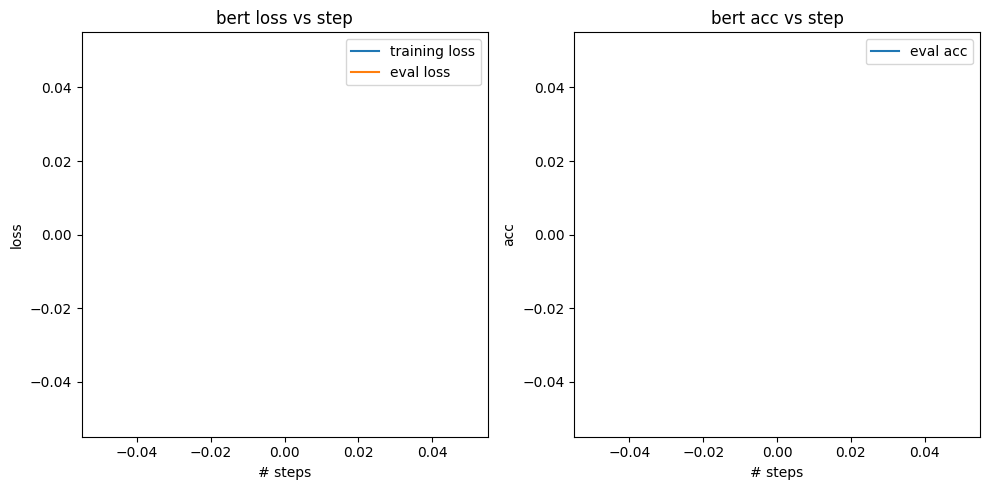

In [39]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("bert loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("bert acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
preds = trainer.predict(data["test"])

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)